# Pràctica 2 - Clasificació

En aquesta pràctica haurem d'analitzar una base de dades i intentra veure quin o quins poden ser els millors classificadors després d'haver fet un anàlisi de les dades.


## Apartat (B): Classificació numèrica 
### EDA expolratory data analysis

En aquest apartat farem un anàlisi de la nostra base de dates, la qual consisteix en, apartir de un seguit de sensors ubicats a diferents músculs, dir quin és el gest que esta articulant amb la mà.

In [1]:
import pandas as pd
import numpy as np

dataset = []

# llegim els quatre fitxes que tenim amb totes les dades
for i in range(4):
    dataset.append(pd.read_csv(f"dataset/{i}.csv", header=None))

dataset = pd.concat(dataset, axis=0)
data = dataset.values

print("Forma de la base de dades:", dataset.shape)

Forma de la base de dades: (11678, 65)


Veiem que el nostre dataset es força gran, ja que no és només que compti amb 11.678 mostres, sinó que també té 65 atribust, dels quals 64 son sensors (8 sensors per cada múscul) i l'últim és el gest que fa la mà. Aquest és un atribut categòric que està composat per 4 classes: 0 : pedra, 1 : paper, 2 : tisores i 3 : ok

In [2]:
# afegim noms a les columnes per ubicar millor els valors
cols = {}

for i in range(64):
    cols[i] = f"m{int(i/8)+1}_s{i%8+1}"
cols[64] = "gesture_class"

dataset = dataset.rename(columns=cols)
dataset.describe()

,m1_s1,m1_s2,m1_s3,m1_s4,m1_s5,m1_s6,m1_s7,m1_s8,m2_s1,m2_s2,...,m7_s8,m8_s1,m8_s2,m8_s3,m8_s4,m8_s5,m8_s6,m8_s7,m8_s8,gesture_class
count,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,...,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000
mean,-0.520380,-0.726837,-0.739082,-0.729748,-0.159103,-0.554890,-1.272649,-0.661843,-0.665953,-0.654222,...,-0.932694,-0.836958,-0.740623,-0.768710,-0.705343,-0.146686,-0.374807,-1.449306,-0.609094,1.503254
std,18.566709,11.766878,4.989944,7.441675,17.850402,25.809528,25.089972,15.408896,18.123854,11.841260,...,15.158993,18.204465,12.005206,4.969758,7.384410,17.841479,25.551082,25.259736,15.530091,1.117541
min,-116.000000,-104.000000,-33.000000,-75.000000,-121.000000,-122.000000,-128.000000,-128.000000,-110.000000,-128.000000,...,-128.000000,-116.000000,-128.000000,-46.000000,-74.000000,-103.000000,-128.000000,-128.000000,-124.000000,0.000000
25%,-9.000000,-4.000000,-3.000000,-4.000000,-10.000000,-15.000000,-6.000000,-8.000000,-9.000000,-4.000000,...,-8.000000,-9.000000,-4.000000,-3.000000,-4.000000,-10.000000,-14.000000,-6.000000,-8.000000,1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,2.000000
75%,7.000000,3.000000,2.000000,3.000000,10.000000,13.000000,4.000000,6.000000,6.000000,3.000000,...,6.000000,6.000000,3.000000,2.000000,3.000000,10.000000,13.000000,3.000000,6.000000,3.000000
max,111.000000,90.000000,34.000000,55.000000,92.000000,127.000000,127.000000,126.000000,127.000000,106.000000,...,114.000000,127.000000,105.000000,29.000000,51.000000,110.000000,127.000000,127.000000,127.000000,3.000000


Podem observar que la distribució dels valors és bastant similar entre els atributs. Tots els sensors tenen mitjanes molt similars i els percentils bastant semblants en quant als valors a més de que tots tenen la centralització en els mateixos valors. 

En quant als gestes de la mà, aquest també semblen que tenim casi la mateixa quantitat de cada gest. Per assegurar-nos, ho comprovarem:

In [3]:
np.unique(data[:,-1], return_counts=True)

(array([0., 1., 2., 3.]), array([2910, 2903, 2943, 2922], dtype=int64))

Podem dir doncs que cada gest és representat en la mateixa mesura que els altres, tot i que hi hagi una diferencia màxima de 40 mostres més en la classe que menys i més en té.

In [42]:
for i in range(65):
    if dataset.isnull().sum()[i] != 0:
        print(f"{i} column is null with {dataset.isnull().sum()[i]} nulls")

Veiem que la nostra dataset tampoc té valors nulls, cosa que facilita el seu tractament.

In [46]:
type(data[0,0])

numpy.float64

In [45]:
type(data[-1, -1])

numpy.float64

Tots els atributs són float64

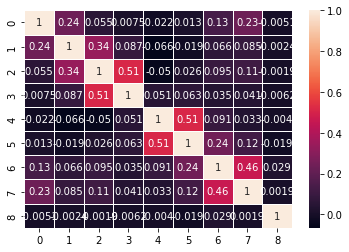

In [7]:
import seaborn as sns
from matplotlib import pyplot as plt

# data del primer múcul (els 8 sensors que el composen)
data1 = np.c_[dataset.values[:, :8], dataset.values[:, -1]]

data1 = pd.DataFrame(data1)

plt.figure()

ax = sns.heatmap(data1.corr(), annot=True, linewidths=.5)

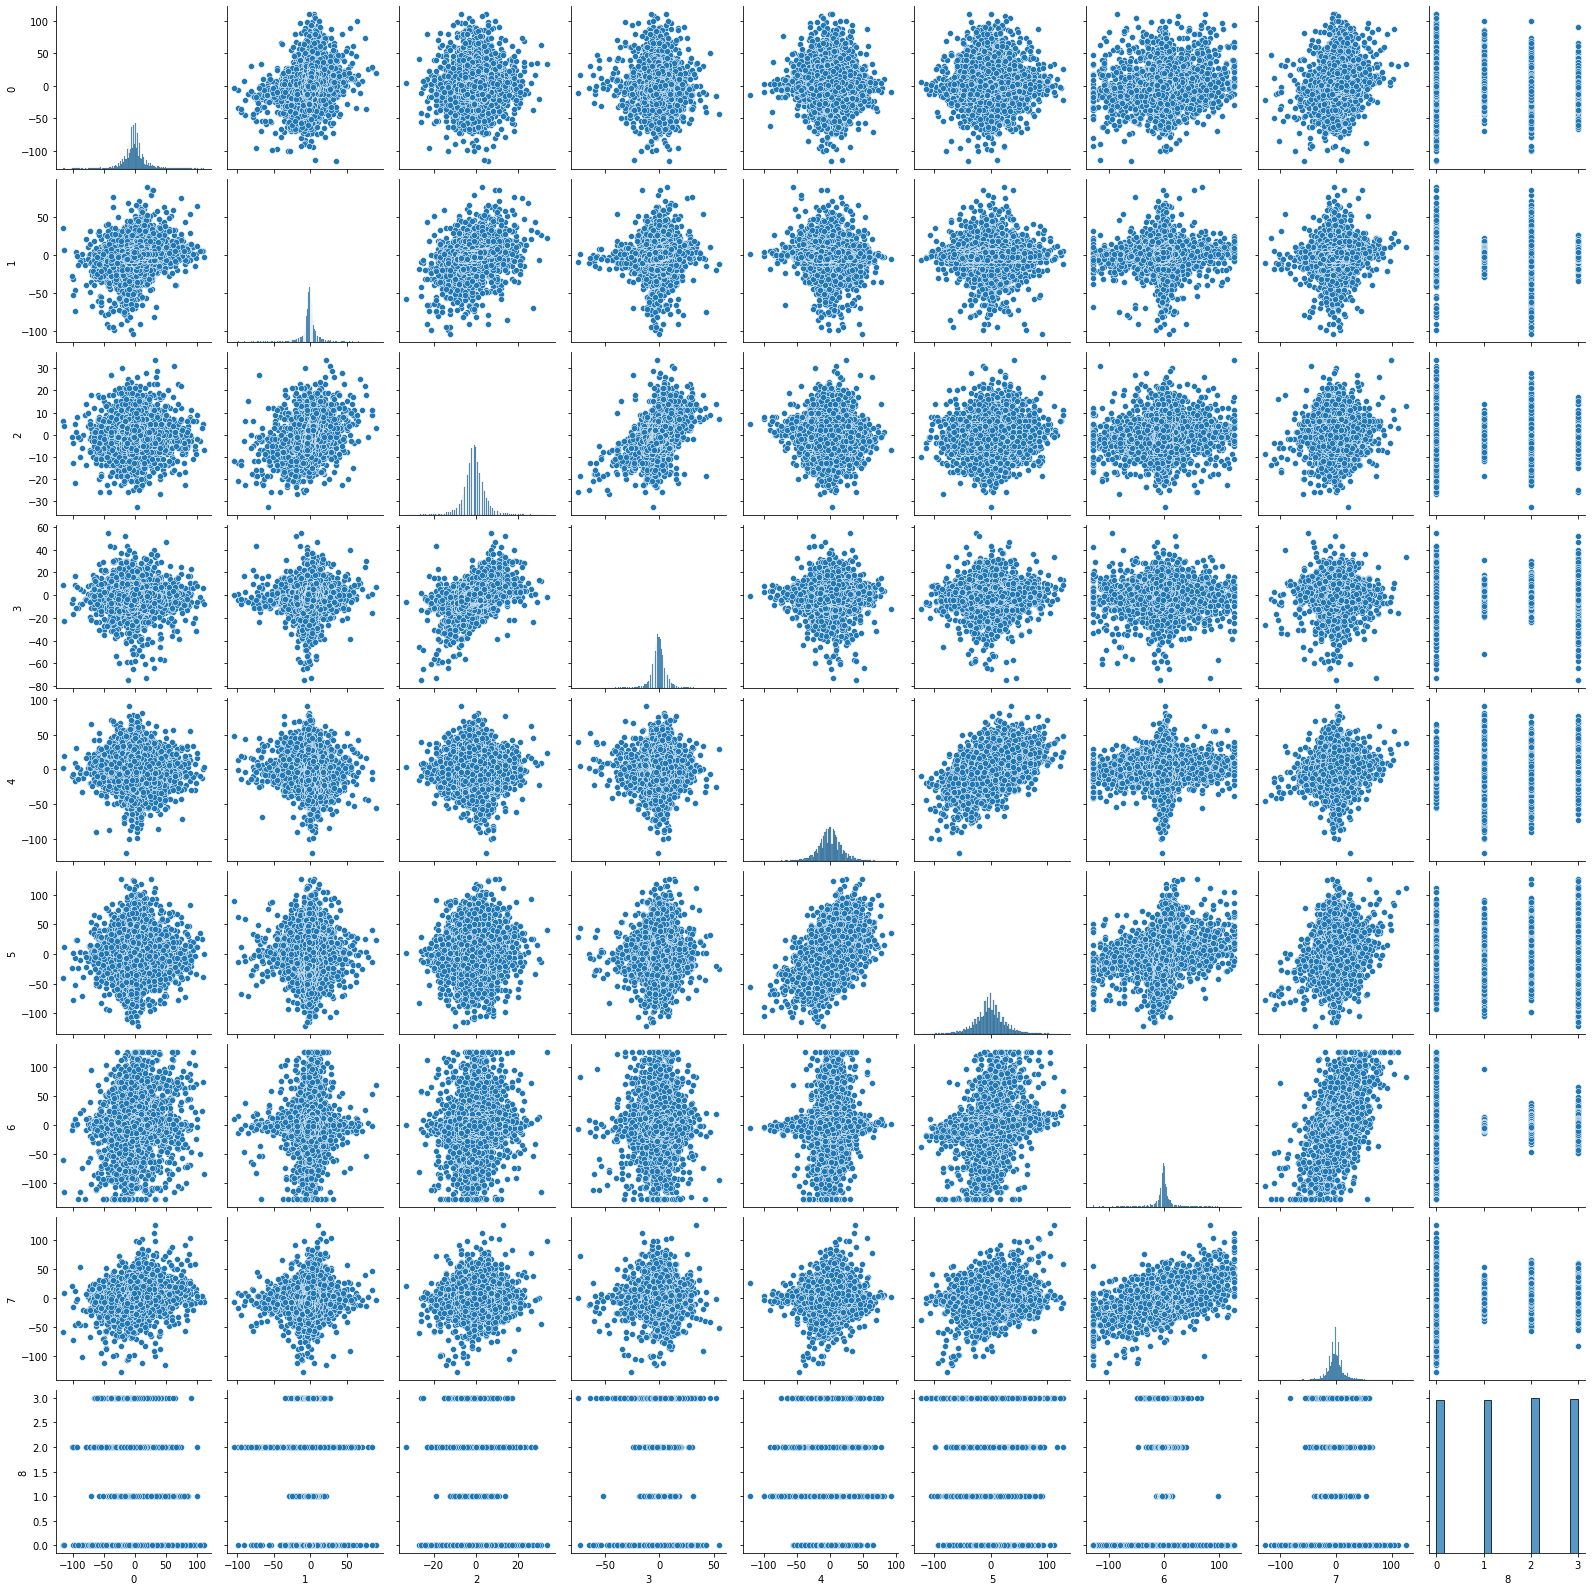

In [9]:
relacio = sns.pairplot(data1)

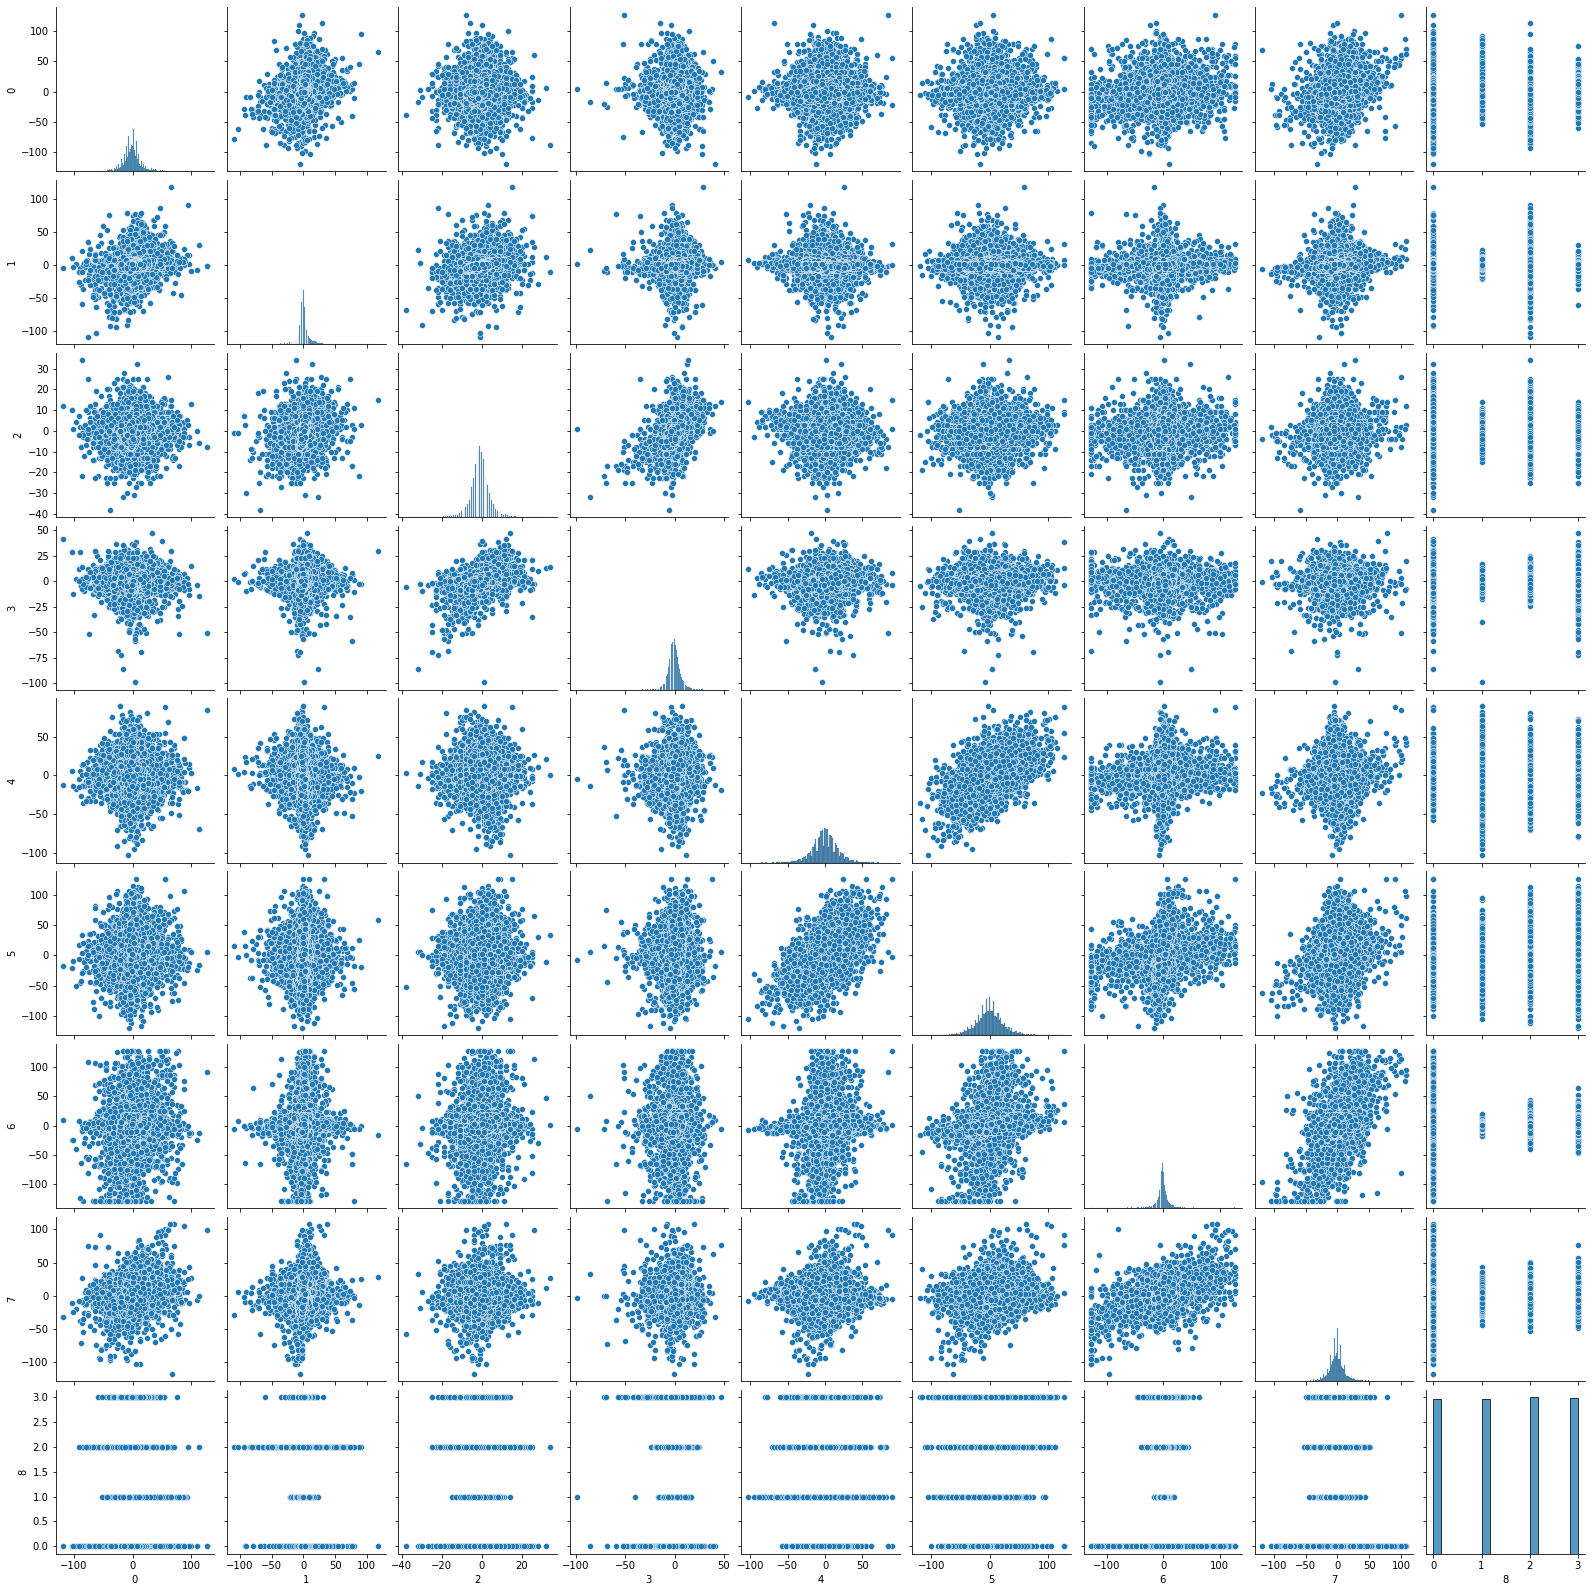

In [9]:
data3 = np.c_[dataset.values[:, 16:24], dataset.values[:, -1]]

data3 = pd.DataFrame(data3)

relacio = sns.pairplot(data3)

Em escollit dos músculs al atzar ja que considerem que per la resta s'aplicarien les mateixes normes. Aquest dos representen de forma general la resta del dataset.

Podem veure, com s'intuia a l'anàlisi de taula de descripció, que els valors dels sensors tenen forma gaussian, tant de forma indivisual com en la relació que representen entre ells.

També podem observar que aquest semblan ja normalitzats per la distrubució que presenten.

## 2 Preprocessing normalitzation, outlier removal, feature selection...

En aquesta secció tractarem les dades per tal de tenir més fàcilitats al treballar amb aquestes.

**S'ha de fer: PCA i regressio logistica, amb pandas mirar files repetides**

In [4]:
dataset.drop_duplicates()

X = data[:, :-1]
y = data[:, -1]

print("Forma de la base de dades:", dataset.shape)
print("Dimensions de la entrada x:", X.shape)
print("Dimensió dels atributs y:", y.shape)

Forma de la base de dades: (11678, 65)
Dimensions de la entrada x: (11678, 64)
Dimensió dels atributs y: (11678,)


In [5]:
from sklearn.preprocessing import normalize

X = normalize(X)

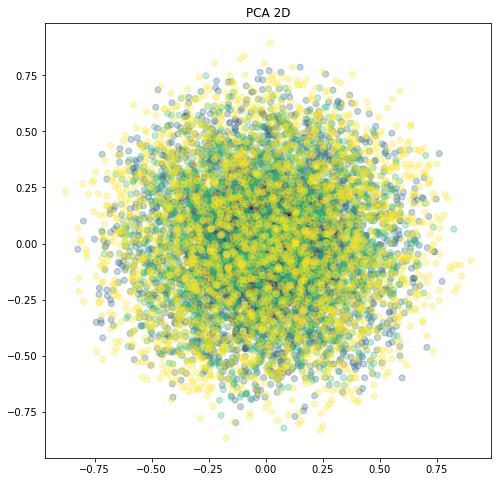

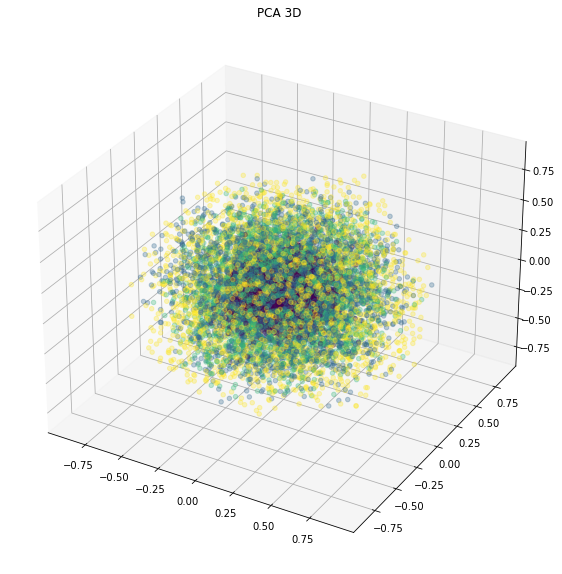

In [8]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
digits = load_digits()

# PCA 
pca = PCA(n_components=3)
projected = pca.fit_transform(X)

# 2D
plt.scatter(projected[:,0],projected[:,1], c= y, alpha = 0.3)
plt.gcf().set_size_inches((8, 8))
plt.title("PCA 2D")
plt.show()

# 3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(projected[:,0], projected[:,1], projected[:,2], c= y, alpha = 0.3)
fig.set_figheight(10)
fig.set_figwidth(10)
plt.title("PCA 3D")
plt.show()

In [14]:
from sklearn.preprocessing import PolynomialFeatures

X
poly = PolynomialFeatures()

poly.fit_transform(X)

poly.get_params()

{'degree': 2, 'include_bias': True, 'interaction_only': False, 'order': 'C'}

## 3 Model Selection

Una vegada fet tot això, entenar el dataset dins d'un model de selecció. Per això provarem varis i els comprovarem entre ells per veure quin és el que podria encaixar millor amb aquest.

Comencem amb un model lineal, ja que aquest són els més senzills. Com el nostre número de mostres passa els 11.000 i ha de predir un valor categoric, ens ha semblat que el millor model és el lienal SVC pertenyent a SVM.

**S'ha de fer: Posar temporitzadors als models, fer un histograma de test i tain de les y**

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

(array([875.,   0.,   0., 896.,   0.,   0., 856.,   0.,   0., 877.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

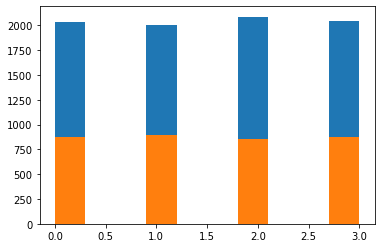

In [67]:
plt.hist(y_train)
plt.hist(y_test)

La taxa d'error és de: 66.66666666666667%
L' accuracy és de: 33.33333333333333%
El recall és de: 33.34105206600058%


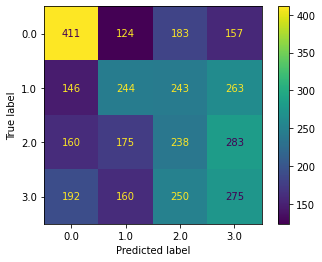

In [134]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import svm
from sklearn.metrics import accuracy_score, recall_score

linear_svc = svm.LinearSVC(random_state=42, dual=False)

linear_svc.fit(X_train, y_train)

y_pred_svc = linear_svc.predict(X_test)

error =  ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svc)
error = 1-(sum(np.diag(error.confusion_matrix)) / sum(error.confusion_matrix.ravel()))

accuracy = accuracy_score(y_test, y_pred_svc)
recall = recall_score(y_test, y_pred_svc, average='macro')

print(f"La taxa d'error és de: {error*100}%")
print(f"L' accuracy és de: {accuracy*100}%")
print(f"El recall és de: {recall*100}%")

La taxa d'error és de: 38.12785388127854%
L' accuracy és de: 61.87214611872146%
El recall és de: 61.32851948502602%


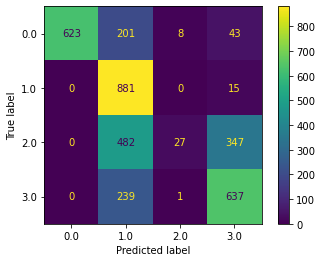

In [135]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=100)

neigh.fit(X_train, y_train)

y_pred_neigh = neigh.predict(X_test)

error =  ConfusionMatrixDisplay.from_predictions(y_test, y_pred_neigh)
error = 1-(sum(np.diag(error.confusion_matrix)) / sum(error.confusion_matrix.ravel()))

accuracy = accuracy_score(y_test, y_pred_neigh)
recall = recall_score(y_test, y_pred_neigh, average='macro')

print(f"La taxa d'error és de: {error*100}%")
print(f"L' accuracy és de: {accuracy*100}%")
print(f"El recall és de: {recall*100}%")

La taxa d'error és de: 7.676940639269403%
L' accuracy és de: 92.3230593607306%
El recall és de: 92.3444949285288%


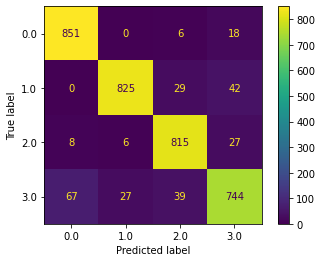

In [136]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=150, max_features=0.1, random_state=42)

forest.fit(X_train, y_train)

y_pred_forest = forest.predict(X_test)

error =  ConfusionMatrixDisplay.from_predictions(y_test, y_pred_forest)
error = 1-(sum(np.diag(error.confusion_matrix)) / sum(error.confusion_matrix.ravel()))

accuracy = accuracy_score(y_test, y_pred_forest)
recall = recall_score(y_test, y_pred_forest, average='macro')

print(f"La taxa d'error és de: {error*100}%")
print(f"L' accuracy és de: {accuracy*100}%")
print(f"El recall és de: {recall*100}%")

## 4 Cross Validation



# Apartat (A)

`np.linspace(min, max, n)` perquè la dataset es massa gran per fer `show_C_efect()`. 